# Benchmark Forecasting

Notebook to validate and plot forecasts.

Sections:
1. Setup & configuration
2. Load + prepare data
3. Temporal holdout validation
4. Fit + forecast
5. Plots by category


In [88]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import forecasting
import plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [51]:
# ---- Data ----
DATA_PATH = "benchmark_data_processed/all_normalized_updated_benchmarks.csv"

# ---- Model ----
MODEL_CONFIG = forecasting.ModelConfig(
    sigmoid="harvey",
    joint=True,
    top_n=3,
)

SAMPLING_CONFIG = forecasting.SamplingConfig(
    draws=2000,
    tune=1000,
    target_accept=0.9,
    seed=42,
    progressbar=True,
)

LANGUAGE: plotting.Language = "fr"
DOCUMENT_TYPE: plotting.DocumentType = "note"

SAVEFIGS = True

# PNG for note (Google Docs), PDF for paper (LaTeX)
IMG_EXT = "png" if DOCUMENT_TYPE == "note" else "pdf"
IMG_DPI = 300

## Load + prepare data

In [5]:
raw = forecasting.load_dataset(DATA_PATH)
data = forecasting.prepare_dataset(raw, top_n=MODEL_CONFIG.top_n)

baselines = pd.read_csv("human_baselines.csv")


## Retrodiction analysis

In [6]:
cutoff_date = pd.to_datetime("2025-01-01")

harvey_joint = forecasting.ModelConfig(
    sigmoid="harvey",
    joint=True,
    top_n=3,
)
harvey_independant = forecasting.ModelConfig(
    sigmoid="harvey",
    joint=False,
    top_n=3,
)
logistic_joint = forecasting.ModelConfig(
    sigmoid="logistic",
    joint=True,
    top_n=3,
)
logistic_independant = forecasting.ModelConfig(
    sigmoid="logistic",
    joint=False,
    top_n=3,
)
retrodiction_models = {
    "Harvey Joint": harvey_joint,
    "Harvey Independant": harvey_independant,
    "Logistic Joint": logistic_joint,
    "Logistic Independant": logistic_independant,
}
retrodiction_idata = {}
for model_name, model_config in retrodiction_models.items():
    print(f"Fitting model: {model_name}")
    idata_forecast = forecasting.temporal_holdout(
        raw,
        cutoff_date=cutoff_date,
        cfg=model_config,
        samp=SAMPLING_CONFIG,
        min_train_points=3,
    )
    retrodiction_idata[model_name] = idata_forecast

Fitting model: Harvey Joint


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 148 seconds.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

Fitting model: Harvey Independant


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 690 seconds.
There were 1612 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

Fitting model: Logistic Joint


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 75 seconds.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

Fitting model: Logistic Independant


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 411 seconds.
There were 2177 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

In [ ]:
plot_style = plotting.PlotStyle(language=LANGUAGE, document_type=DOCUMENT_TYPE)

for model_name, idata_forecast in retrodiction_idata.items():
    print(f"Evaluating model: {model_name}")
    print("CRPS:", forecasting.crps_score(idata_forecast))
    print("RMSE:", forecasting.point_error(idata_forecast, metric="RMSE"))
    print("MAE:", forecasting.point_error(idata_forecast, metric="MAE"))
    fig, ax = plotting.plot_calibration_curve(idata_forecast, n_points=20, plot_style=plot_style)
    if SAVEFIGS:
        fig.savefig(
            f"Images/3-Calibration/{model_name.replace(' ', '_').lower()}_{plot_style.language}_{plot_style.document_type}.{IMG_EXT}",
            dpi=IMG_DPI,
            bbox_inches="tight",
        )

plt.show()

## Fit + forecast

In [15]:
idata_forecast, model_forecast = forecasting.fit(data, MODEL_CONFIG, SAMPLING_CONFIG)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 136 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.


In [16]:
END_DATE = pd.to_datetime("2030-03-01")
forecast_df = forecasting.generate_forecast(
    idata_forecast,
    model_forecast,
    prepared_frontier=data,
    end_date=END_DATE,
    n_points=250,
    ci_level=0.8,
)

forecast_df.head()

/Users/jeremyandreolettigpaipolicylab/Documents/Recherche/Model_Benchmark_forecasting/forecasting.py:336: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: _date_grid_for_benchmark(g, end_date=end_date, n_points=n_points))
Sampling: []


,release_date,days,benchmark,category,mu_mean,mu_lower,mu_upper,mean_tau_days,mean_tau
0,2019-11-05 00:00:00.000000000,0,ARC (AI2),Domain Specific Questions,0.293002,0.251397,0.343971,944.456678,2022-06-06 10:57:36.939925186
1,2019-11-20 03:16:37.590361445,15,ARC (AI2),Domain Specific Questions,0.294428,0.251595,0.346383,944.456678,2022-06-06 10:57:36.939925186
2,2019-12-05 06:33:15.180722891,30,ARC (AI2),Domain Specific Questions,0.295909,0.251830,0.348721,944.456678,2022-06-06 10:57:36.939925186
3,2019-12-20 09:49:52.771084337,45,ARC (AI2),Domain Specific Questions,0.297448,0.252096,0.351226,944.456678,2022-06-06 10:57:36.939925186
4,2020-01-04 13:06:30.361445783,60,ARC (AI2),Domain Specific Questions,0.299048,0.252399,0.353834,944.456678,2022-06-06 10:57:36.939925186


### Forecast plots by category

In [93]:
if "category" in data.columns:
    categories = list(data["category"].dropna().unique())
else:
    categories = ["all"]

plot_style = plotting.PlotStyle(language=LANGUAGE, document_type=DOCUMENT_TYPE)
for cat in categories:
    obs_cat = data if cat == "all" else data.loc[data["category"] == cat]
    pred_cat = (
        forecast_df if cat == "all" else forecast_df.loc[forecast_df["category"] == cat]
    )

    fig, ax = plotting.plot_forecasts_by_category(
        observed=obs_cat,
        forecast=pred_cat,
        baselines=baselines,
        end_date=END_DATE,
        category_name=cat,
        plot_style=plot_style,
    )
    if SAVEFIGS:
        fig.savefig(
            f"Images/2-Categories/forecast_{cat}_{plot_style.language}_{plot_style.document_type}.{IMG_EXT}",
            dpi=IMG_DPI,
            bbox_inches="tight",
        )
plt.show()

/var/folders/ct/fw960pjx4l1d652ll2y6zk5c0000gp/T/ipykernel_42359/1139993988.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### Posterior: proportion of benchmarks saturated by 2030


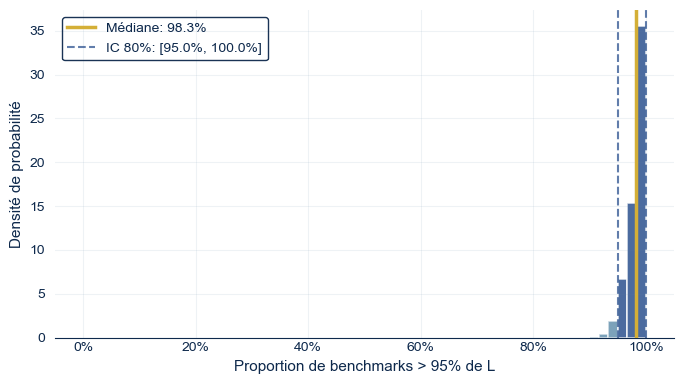

{'n_benchmarks': 60,
 'n_samples': 8000,
 'mean': 0.9766958333333331,
 'median': 0.9833333333333333,
 'std': 0.018050061076381737,
 'ci_level': 0.8,
 'ci': (0.95, 1.0),
 'ci95': (0.9333333333333333, 1.0),
 'target_date': Timestamp('2030-01-01 00:00:00'),
 'saturation_fraction': 0.95}

In [37]:
SATURATION_FRACTION = 0.95
SATURATION_TARGET_DATE = pd.Timestamp("2030-01-01")

plot_style = plotting.PlotStyle(language=LANGUAGE, document_type=DOCUMENT_TYPE)
fig, ax, sat_summary = plotting.plot_saturation_proportion_posterior(
    idata_forecast,
    prepared_frontier=data,
    target_date=SATURATION_TARGET_DATE,
    saturation_fraction=SATURATION_FRACTION,
    ci_level=0.80,
    plot_style=plot_style,
)
if SAVEFIGS:
    fig.savefig(
        f"Images/1-Note-figures/saturation_{plot_style.language}_{plot_style.document_type}.{IMG_EXT}",
        dpi=IMG_DPI,
        bbox_inches="tight",
    )
plt.show()

sat_summary

## Asymmetry visualization (Harvey curves vs logistic)

In [36]:
# Train a separate model for the asymmetry figure (kept independent from the forecast model).
CFG_ASYM = forecasting.ModelConfig(
    sigmoid="harvey",
    joint=True,
    top_n=3,
)

SAMP_ASYM = forecasting.SamplingConfig(
    draws=2000,
    tune=1000,
    target_accept=0.9,
    seed=42,
    progressbar=True,
)

idata_asym, _model_asym = forecasting.fit(data, CFG_ASYM, SAMP_ASYM)


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 1_147 draw iterations (4_000 + 4_588 draws total) took 114 seconds.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


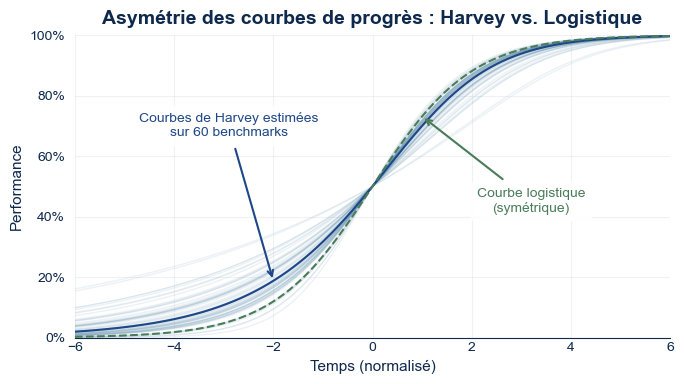

In [ ]:
plot_style = plotting.PlotStyle(language=LANGUAGE, document_type=DOCUMENT_TYPE)
plotting.plot_harvey_asymmetry(idata_asym, plot_style=plot_style)
if SAVEFIGS:
    plt.savefig(
        f"Images/1-Note-figures/asymmetry_{plot_style.language}_{plot_style.document_type}.{IMG_EXT}",
        dpi=IMG_DPI,
        bbox_inches="tight",
    )
plt.show()